In [1]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tqdm
import scipy
from scipy import signal
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
import sys
import warnings
import statsmodels
warnings.filterwarnings('ignore')
#sns.set_context('talk')
#sns.set_style('whitegrid')
cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']

modulename = 'multiprocess' #essing


def calc_plam(num_pulses,lam1,lam2):
    pow_lam1 = np.power(lam1,num_pulses)
    pow_lam2 = np.power(lam2,num_pulses)
    exp_lam1 = np.exp(-lam1)
    exp_lam2 = np.exp(-lam2)
    return pow_lam1*exp_lam1/(pow_lam1*exp_lam1+pow_lam2*exp_lam2)

def compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np,Nmin=1):
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2+sig_dN**2)
    phigh = norm.cdf((Nps-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

def compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np,Nmin=1):
    sig_Nps = sig_Np[Nps-Nmin]
    sig = np.sqrt(sig_Nps**2+sig_dN**2)
    phigh = norm.cdf((weighted_odor-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

def compute_phigh(Np,Nb,sig_dN,sig_Np):
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_sq(Np,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_lin(Np,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18):
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    return compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)

def compute_logp_correct_sq_weighted(choices,weighted_odor,Nps,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    return compute_logp_correct_weighted(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np)
    
def compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np):
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_weighted(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np):
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_lin(choices,Nps,Nb,sig_dN,sig_0,Nmin=1,Nmax=18):
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    pcorrect = compute_pcorrect(choices,Nps,Nb,0,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_lin_weighted(choices,weighted_odor,Nps,Nb,sig_0, sig_dN,ksig,Nmin=1,Nmax=18):
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    pcorrect = compute_pcorrect_weighted(choices,weighted_odor,Nps,Nb,sig_dN,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()


def get_pulses(choices,cum_odor,min_pulse,max_pulse):
    all_Nps = np.ceil(cum_odor).astype(np.int)
    ind_selected = np.logical_and(all_Nps>=min_pulse,all_Nps<=max_pulse)
    #print(ind_selected.shape)
    return choices[ind_selected], all_Nps[ind_selected]

def get_odor_profile_actual(odor_profile):
    kernel = np.load('odor_kernel_50ms.npy')
    pulse_onsets = (np.diff(odor_profile)>0).astype(np.float)
    pulse_onsets_shifted = np.concatenate((np.zeros((70,)),pulse_onsets,np.zeros(131)))
    odor_profile_actual = np.convolve(pulse_onsets_shifted,kernel,mode='same')
    return odor_profile_actual

def get_conv_odor(session):
    num_trials = session['num_trials']
    conv_odor = np.zeros((num_trials,5000))
    conv_weights_all = np.zeros((num_trials,5000))
    sniff_kernel = np.load('inhalation_kernel_fine_weights_active.npy')
    sniff_kernel = sniff_kernel/sniff_kernel.mean()
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,10,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=120)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        conv_weights = np.zeros((10000,))
        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            conv_weights[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(sniff_kernel,nsample)*250/nsample
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        conv_weights_sampling_epoch = conv_weights[2500:7500]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        odor_effective = odor*conv_weights_sampling_epoch
        conv_odor[i_trial,:] = odor_effective
        conv_weights_all[i_trial,:] = conv_weights_sampling_epoch
    return conv_odor, conv_weights_all

def get_sniff_histogram(session,shuffled=False):
    bins = np.linspace(0,250,16)
    num_trials = session['num_trials']
    sniff_hist = np.zeros((num_trials,15))
    sniff_kernel = np.load('inhalation_kernel_fine_weights_active.npy')
    sniff_kernel = sniff_kernel/sniff_kernel.mean()
    
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        #print(sniff_raw.shape)
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        #print(sniff.shape)
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        sniff_phase = np.zeros((10000,))

        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        sniff_phase_sampling_epoch = sniff_phase[2500:]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        if shuffled:
            n_pulses = (np.diff(odor_command)==100).sum()
            valve_onset = np.random.randint(0,5000,(n_pulses,))
        else:
            valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
        odor_onset = valve_onset + 20
        odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
        hist,_ = np.histogram(odor_phase,bins)
        sniff_hist[i_trial,:] = hist
    return sniff_hist

def get_sniff_durations(session):
    num_trials = session['num_trials']
    sniff_durations = np.zeros((num_trials,50))
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(-sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        sniff_duration = np.diff(sniff_onset)
        sniff_durations[i_trial,:len(sniff_duration)] = sniff_duration
    return sniff_durations

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

def get_autocorr(session,n):
    high_trials = session['high_trials']
    autocorr = list()
    for i in range(n):
        autocorr.append(np.corrcoef(high_trials[i+1:],high_trials[:-(i+1)])[0][1])
    return np.array(autocorr)

from statsmodels.distributions.empirical_distribution import ECDF



In [2]:
bins = np.linspace(0,250,16)
print(bins)
    

[  0.          16.66666667  33.33333333  50.          66.66666667
  83.33333333 100.         116.66666667 133.33333333 150.
 166.66666667 183.33333333 200.         216.66666667 233.33333333
 250.        ]


In [2]:
# compute psychjometrics of each animal

path = os.getcwd() + '/Session/'
savepath = os.getcwd() + '/Figures/Distribution_analysis'
#print(path)
dir_list = os.listdir(path)

num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20
num_hist = 6
pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)
phigh_list = list()
performance_list = list()
bin_counts_list = list()
all_trial_odor_list = list()
all_high_choices_list = list()
all_cum_odor_list = list()
all_cum_conv_odor_list = list()
all_conv_odor_list = list()
all_correct_trials_list = list()
all_sniff_durations_list = list()
all_sniff_hist_list = list()
all_sniff_hist_shuffled_list = list()
all_previous_trial_list = list()
all_int_trials_list = list()
autocorr_list = list()
#animals = ['Shorthair']
#animal_list = [['Tabby']]
animal_list = [['Tabby'],['Bengal'],['Shorthair'],['Banner'],['Natasha'],['Stark'],['Peterparker']] #]#['Bengal'],['Shorthair'],['Tabby'],

for animals in animal_list:
    fname_list = list()

    for date_number in range(20190419,20220526):
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)

    num_all_trials = 0
    
    all_trial_odor = np.zeros((0,5000))
    all_conv_weights = np.zeros((0,5000))
    all_conv_odor = np.zeros((0,5000))
    all_cum_odor = np.zeros((0,))
    all_cum_conv_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_sniff_durations = np.zeros(0,)
    all_sniff_hist = np.zeros((0,15))
    all_sniff_hist_shuffled = np.zeros((0,15))
    all_previous_trials = np.zeros((0,num_hist))
    all_int_trials  = np.zeros((0,))
    
    for i_file in tnrange(len(fname_list)):
        session_id = 0
        fname = fname_list[i_file]
        #print(fname)
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                if session_list[0]['type'] == 'random':
                    if session_list[0]['delay_time'] == 5:
                        if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:
                            if session_list[0]['low_count'] < 5:

                                num_trials = session['num_trials']
                                #print(num_trials)
                                autocorr_list.append(get_autocorr(session,num_hist))
                                session['conv_trial_odor'],session['conv_weights'] = get_conv_odor(session)
                                session['sniff_durations'] = get_sniff_durations(session)
                                #print(session['high_trials'])
                                #conv_fname = 'conv_' + session_fname
                                #conv_session_list = list()
                                #conv_session_list.append(session)
                                #with open(conv_fname,'wb') as handle:
                                #    pickle.dump(session,handle,pickle.HIGHEST_PROTOCOL)


                                non_idle_trials = np.invert(session['idle_trials'])
                                #print(non_idle_trials.shape, non_idle_trials)


                                correct_trials = session['correct_trials'][non_idle_trials]
                                #print(correct_trials.shape)
                                high_trials = session['high_trials'][non_idle_trials]
                                low_trials = session['low_trials'][non_idle_trials]
                                high_choices = (correct_trials==high_trials)
                                trial_odor = session['trial_odor'][non_idle_trials]
                                conv_odor = session['conv_trial_odor'][non_idle_trials]
                                #conv_weights = session['conv_weights'][non_idle_trials]
                                sniff_durations = session['sniff_durations'][non_idle_trials]
                                sniff_durations = sniff_durations[sniff_durations>0] #pasting all the sniff durations of the session in just one array

                                sniff_hist = get_sniff_histogram(session,False)[non_idle_trials]
                                sniff_hist_shuffled = get_sniff_histogram(session,True)[non_idle_trials]
                                cum_odor = trial_odor.sum(axis=1)/5000
                                #cum_conv_odor = conv_odor.sum(axis=1)/50
                                #print(conv_odor.shape)
                                #intermittency = ECDF(conv_odor)
                                #int_trial = intermittency(max(conv_odor)*0.1)
                                num_trials_taken = len(high_trials) - num_hist
                                previous_ind = np.arange(num_trials_taken).reshape(-1,1)+np.arange(0,num_hist)
                                previous_trials = high_choices[previous_ind]
                                all_conv_odor = np.append(all_conv_odor, conv_odor[num_hist:], axis=0)
                                #print(len(cum_odor[10:]))
                                all_trial_odor = np.append(all_trial_odor, trial_odor[num_hist:,:5000], axis=0)
                                #all_conv_weights = np.append(all_conv_weights, conv_weights[num_hist:], axis=0)
                                all_correct_trials = np.append(all_correct_trials,correct_trials[num_hist:])
                                all_high_trials = np.append(all_high_trials,high_trials[num_hist:])
                                all_high_choices = np.append(all_high_choices,high_choices[num_hist:])
                                all_cum_odor = np.append(all_cum_odor,cum_odor[num_hist:])
                                #all_cum_conv_odor = np.append(all_cum_conv_odor,cum_conv_odor[num_hist:])
                                all_sniff_durations = np.append(all_sniff_durations,sniff_durations[num_hist:])
                                all_sniff_hist = np.append(all_sniff_hist,sniff_hist[num_hist:],axis=0)
                                #print(all_sniff_hist.shape)
                                all_sniff_hist_shuffled = np.append(all_sniff_hist_shuffled,sniff_hist_shuffled[num_hist:],axis=0)
                                all_previous_trials = np.append(all_previous_trials,previous_trials,axis=0)
                                #print(all_sniff_hist.shape,all_previous_trials.shape)
            
        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
        all_correct_trials = all_correct_trials[good_trials]
        all_high_trials = all_high_trials[good_trials]
        all_low_trials = all_low_trials[good_trials]
        all_high_choices = all_high_choices[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        #all_cum_conv_odor = all_cum_conv_odor[good_trials]
        all_conv_odor = all_conv_odor[good_trials,:]
        all_trial_odor = all_trial_odor[good_trials,:]
        #all_int_trials = all_int_trials[good_trials]
        #all_conv_weights = all_conv_weights[good_trials,:]
        all_sniff_hist = all_sniff_hist[good_trials,:]
        all_sniff_hist_shuffled = all_sniff_hist_shuffled[good_trials,:]
        all_previous_trials = all_previous_trials[good_trials,:]
    
    #np.save('sniff_analysis_correct/' + animals[0] + '_' + 'conv_odor.npy', all_conv_odor)
    #np.save('sniff_analysis_correct/' + animals[0] + '_' + 'all_high_trials.npy', all_high_trials)
    #np.save('sniff_analysis_correct/' + animals[0] + '_' + 'all_high_choices.npy', all_high_choices)
    #np.save('sniff_analysis_correct/' + animals[0] + '_' + 'all_true_pulses_number.npy', all_cum_odor)
    #np.save('sniff_analysis_correct/' + animals[0] + '_' + 'all_odor_commands.npy', all_trial_odor)
    #np.save('sniff_analysis_correct/' + animals[0] + '_' + 'all_conv_weights.npy', all_conv_weights)
    all_correct_trials_list.append(all_correct_trials)
    all_trial_odor_list.append(all_trial_odor)
    all_high_choices_list.append(all_high_choices)
    all_cum_odor_list.append(all_cum_odor)
    all_conv_odor_list.append(all_conv_odor)
    all_sniff_durations_list.append(all_sniff_durations)
    all_sniff_hist_list.append(all_sniff_hist)
    all_sniff_hist_shuffled_list.append(all_sniff_hist_shuffled)
    all_previous_trial_list.append(all_previous_trials)
    all_int_trials_list.append(all_int_trials)

autocorr_mat = np.array(autocorr_list)


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

In [3]:
phigh = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)

for i in range(num_bins):
    selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts[i] = num_selected
    phigh[i,0] = selected.mean()
    phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
phigh_list.append(phigh)
performance_list.append(performance)
bin_counts_list.append(bin_counts)

In [5]:
norm_given_odor = np.zeros((0,))
all_sniff_hist = np.zeros((0,15))
all_previous_trials = np.zeros((0,num_hist))
all_correct_trials = np.zeros((0,))

In [6]:
animal_ind = 6
norm_given_odor = all_cum_odor_list[animal_ind]
#norm_inhaled_odor = (all_cum_conv_odor - all_cum_conv_odor.mean())/all_cum_conv_odor.std()*all_cum_odor.std() + all_cum_odor.mean()
all_correct_trials = all_correct_trials_list[animal_ind].astype(bool)

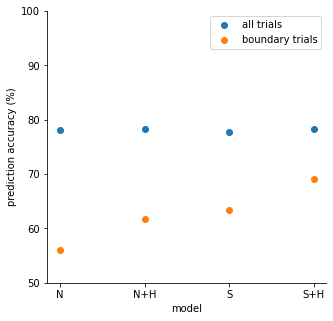

In [8]:
from sklearn.linear_model import LogisticRegression


selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<20)
X1 = norm_given_odor[selected_trials].reshape(-1,1)
X2 = all_sniff_hist_list[animal_ind][selected_trials]
X3 = np.append(X2,all_previous_trial_list[animal_ind][selected_trials],axis=1)
X4 = np.append(X1,all_previous_trial_list[animal_ind][selected_trials],axis=1)
y = all_high_choices_list[animal_ind][selected_trials]
clf1 = LogisticRegression().fit(X1, y)
clf2 = LogisticRegression().fit(X2, y)
clf3 = LogisticRegression().fit(X3, y)
clf4 = LogisticRegression().fit(X4, y)
accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
positions = [1,2,3,4]
labels = ['N', 'N+H', 'S','S+H']
plt.figure(figsize=(5,5))
plt.scatter(positions,accuracy)

selected_trials = np.logical_and(norm_given_odor>6,norm_given_odor<10)
X1 = norm_given_odor[selected_trials].reshape(-1,1)
X2 = all_sniff_hist_list[animal_ind][selected_trials]
X3 = np.append(X2,all_previous_trial_list[animal_ind][selected_trials],axis=1)
X4 = np.append(X1,all_previous_trial_list[animal_ind][selected_trials],axis=1)
y = all_high_choices_list[animal_ind][selected_trials]
clf1 = LogisticRegression().fit(X1, y)
clf2 = LogisticRegression().fit(X2, y)
clf3 = LogisticRegression().fit(X3, y)
clf4 = LogisticRegression().fit(X4, y)
accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
plt.scatter([1,2,3,4],accuracy)


plt.ylim(50,100)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.xlabel('model')
plt.ylabel('prediction accuracy (%)')
plt.legend(['all trials','boundary trials'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig('figures/logistic_model_comparison.svg')
#plt.show()

In [329]:
selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<20)
X1 = norm_given_odor[selected_trials].reshape(-1,1)
X2 = all_sniff_hist_list[animal_ind][selected_trials]
X3 = np.append(X2,all_previous_trial_list[animal_ind][selected_trials],axis=1)
X4 = np.append(X1,all_previous_trial_list[animal_ind][selected_trials],axis=1)
y = all_high_choices_list[animal_ind][selected_trials]
clf1 = LogisticRegression().fit(X1, y)
clf2 = LogisticRegression().fit(X2, y)
clf3 = LogisticRegression().fit(X3, y)
clf4 = LogisticRegression().fit(X4, y)
accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]

15


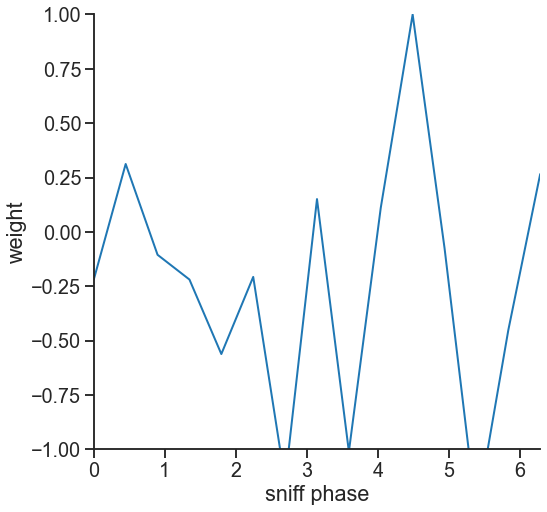

In [13]:
import h5py
with h5py.File('HW_Data/pack_data_new/Sphinx_sniff_kernel.mat', 'r') as file:
    dset = file['Sphinx_sniff_kernel']
    kernels = dset[:]
    sniff_kernel = kernels.mean(axis=1).squeeze()

sniff_rolled = sniff_kernel
sniff_rolled = sniff_rolled/sniff_rolled.max()
weights = clf2.coef_[0][0:15]/clf2.coef_[0][0:15].max()
print(len(weights))
weights = weights/weights.max()
T = np.linspace(0,2*np.pi,15)

plt.figure(figsize=(8,8))
#plt.plot(T,sniff_rolled)
plt.plot(T,weights)
#plt.legend(['calcium_imaging','behavior'])
plt.xlabel('sniff phase')
plt.ylabel('weight')
plt.xlim(0,2*np.pi)
plt.ylim(-1,1)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig('figures/sniff_kernel_match.svg')
plt.show()

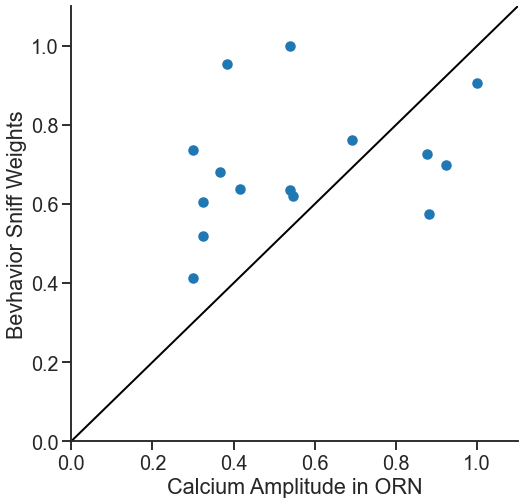

0.2867512867922519


In [314]:
xsk = sniff_rolled
ysk = weights
slope, intercept, r_value, p_value, std_err = linregress(xsk,ysk)
xid = np.linspace(-1,2,20)
yid = np.linspace(-1,2,20)
plt.figure(figsize=(8,8))
plt.scatter(sniff_rolled,weights)
plt.plot(xid,yid,'k')
plt.xlabel('Calcium Amplitude in ORN')
plt.ylabel('Bevhavior Sniff Weights')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/ca_vs_weights.svg')
plt.show()
print(r_value)

In [83]:
print(len(clf3.coef_[0]))
print(len(clf4.coef_[0]))

print(X2.shape)


21
7
(3909, 15)


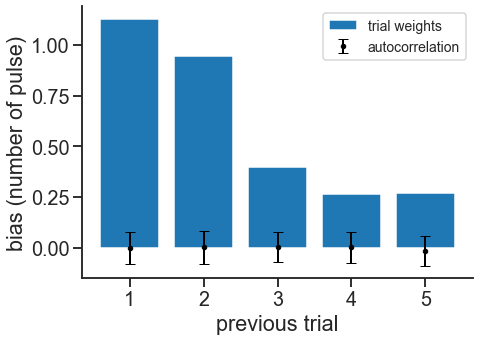

In [84]:
trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
plt.figure(figsize=(7,5))
plt.bar(np.arange(1,num_hist),trial_history)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('previous trial')
plt.ylabel('bias (number of pulse)')
plt.errorbar(np.arange(1,num_hist),autocorr_mat.mean(axis=0)[0:5],yerr=autocorr_mat.std(axis=0)[0:5],ecolor='k',capsize=5,marker='.',markerfacecolor='k',markeredgecolor='k',linestyle='')
plt.legend(['trial weights','autocorrelation'])
#plt.savefig('figures/trial_history_bias.svg')
plt.show()

In [85]:
clf1 = LogisticRegression().fit(X1, y)
clf2 = LogisticRegression().fit(X2, y)
clf3 = LogisticRegression().fit(X3, y)

In [332]:
num_processes = 16
N_bootstrap = 4000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter


output_list_high = list()

for animal_ind in range(len(all_correct_trials_list)):
#for animal_ind in range(1,2):
    norm_given_odor = all_cum_odor_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<20)
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    
    
    
    def worker(x):
        ind_bootstrap = np.random.randint(0,len(all_correct_trials),size=(N_bootstrap,))
        new_high_choices = all_high_choices[ind_bootstrap]
        new_cum_odor = all_cum_odor[ind_bootstrap]

        X1 = norm_given_odor[ind_bootstrap].reshape(-1,1)
        X2 = all_sniff_hist[ind_bootstrap]
        X3 = np.append(X2,all_previous_trial[ind_bootstrap],axis=1)
        X4 = np.append(X1,all_previous_trial[ind_bootstrap],axis=1)
        y = all_high_choices[ind_bootstrap]

        clf1 = LogisticRegression().fit(X1, y)
        clf2 = LogisticRegression().fit(X2, y)
        clf3 = LogisticRegression().fit(X3, y)
        clf4 = LogisticRegression().fit(X4, y)
        accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
        weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
        weights = weights/weights.max()
        trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
        return accuracy,weights,trial_history

    output = list()
    
    for i in tnrange(num_iter):
        output.append(worker(0))
    output_list_high.append(output)

#     p = Pool(processes=1)
#     for i in tnrange(num_batch):
#         batch_output = p.map(worker,range(batch_iter))
#         output.extend(batch_output)
#     p.close()
#     output_list_high.append(output)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [333]:
num_processes = 16
N_bootstrap = 400
num_iter = 1000
batch_iter = 100
num_batch = num_iter//batch_iter


output_list_low = list()

for animal_ind in range(len(all_correct_trials_list)):
#for animal_ind in range(1,2):
    norm_given_odor = all_cum_odor_list[animal_ind]
    all_correct_trials = all_correct_trials_list[animal_ind].astype(bool)
    all_high_choices = all_high_choices_list[animal_ind]
    all_cum_odor = all_cum_odor_list[animal_ind]
    
    
    selected_trials = np.logical_and(norm_given_odor>6,norm_given_odor<10)
    
    
    def worker(x):
        ind_bootstrap = np.random.randint(0,len(all_correct_trials[selected_trials]),size=(N_bootstrap,))
        new_high_choices = all_high_choices[ind_bootstrap]
        new_cum_odor = all_cum_odor[ind_bootstrap]

        X1 = norm_given_odor[selected_trials][ind_bootstrap].reshape(-1,1)
        X2 = all_sniff_hist_list[animal_ind][selected_trials][ind_bootstrap]
        X3 = np.append(X2,all_previous_trial_list[animal_ind][selected_trials][ind_bootstrap],axis=1)
        X4 = np.append(X1,all_previous_trial_list[animal_ind][selected_trials][ind_bootstrap],axis=1)
        y = all_high_choices_list[animal_ind][selected_trials][ind_bootstrap]

        clf1 = LogisticRegression().fit(X1, y)
        clf2 = LogisticRegression().fit(X2, y)
        clf3 = LogisticRegression().fit(X3, y)
        clf4 = LogisticRegression().fit(X4, y)
        accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
        weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
        weights = weights/weights.max()
        trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
        return accuracy,weights,trial_history

    output = list()

    with mp.Pool(processes=16) as pool:
        for i in tnrange(num_batch):
            batch_output = pool.map(worker,range(batch_iter))
            output.extend(batch_output)
        pool.close()
    output_list_low.append(output)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [222]:
animal_ind = 1
accuracy_list = list()
weights_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output_list_high[animal_ind][i][0])
    weights_list.append(output_list_high[animal_ind][i][1])
    trial_history_list.append(output_list_high[animal_ind][i][2])

In [223]:
accuracy_mat = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean = accuracy_mat.mean(axis=0)
accuracy_std = accuracy_mat.std(axis=0)
accuracy_error = 1.96*accuracy_std/np.sqrt(num_iter)

weights_mat = np.concatenate(weights_list).reshape(-1,15)
weights_mean = weights_mat.mean(axis=0)
weights_std = weights_mat.std(axis=0)
weights_error = 1.96*weights_std/np.sqrt(num_iter)

trial_history_mat = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean = trial_history_mat.mean(axis=0)
trial_history_std = trial_history_mat.std(axis=0)
trial_history_error = 1.96*trial_history_std/np.sqrt(num_iter)

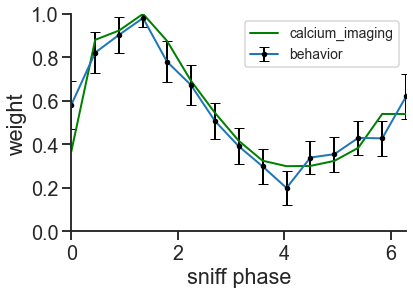

<Figure size 216x216 with 0 Axes>

In [224]:
phase = np.linspace(0,2*np.pi,15)
plt.errorbar(phase,weights_mean,yerr=weights_std,ecolor='k',capsize=5,marker='.',markerfacecolor='k',markeredgecolor='k')
plt.plot(T,sniff_rolled,color='g')
plt.legend(['calcium_imaging','behavior'])
plt.xlabel('sniff phase')
plt.ylabel('weight')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/sniff_kernel_match.svg')
plt.show()
phase = np.linspace(0,2*np.pi,15)
plt.figure(figsize=(3,3))
plt.show()

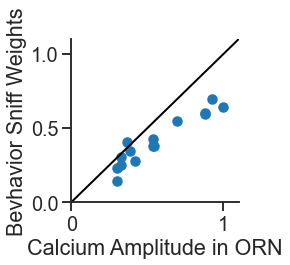

0.9443017151295345


In [225]:

plt.figure(figsize=(3,3))

xsk = sniff_rolled
ysk = weights_mean
slope, intercept, r_value, p_value, std_err = linregress(xsk,ysk)
xid = np.linspace(-1,2,20)
yid = np.linspace(-1,2,20)

plt.scatter(sniff_rolled,weights)
plt.plot(xid,yid,'k')
plt.xlabel('Calcium Amplitude in ORN')
plt.ylabel('Bevhavior Sniff Weights')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/ca_vs_weights.svg')
plt.show()
print(r_value)

In [9]:
num_processes = 16
N_bootstrap = 12000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15))
all_sniff_hist_shuffled_all = np.zeros((0,15))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    norm_given_odor = all_cum_odor_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<20)
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
    
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
    weights = weights/weights.max()
    weights_shuffled = clf5.coef_[0][0:15]/clf5.coef_[0][0:15].max()
    weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
    return accuracy,weights,trial_history,weights_shuffled

output = list()
    
for i in tnrange(num_iter):
    output.append(worker(0))

    

  0%|          | 0/1000 [00:00<?, ?it/s]

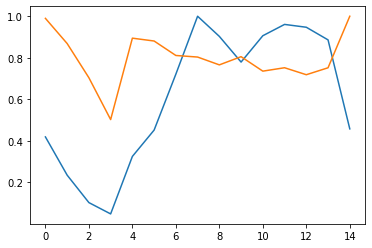

In [10]:
accuracy_list = list()
weights_list = list()
weights_shuffled_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output[i][0])
    weights_list.append(output[i][1])
    trial_history_list.append(output[i][2])
    weights_shuffled_list.append(output[i][3])

accuracy_mat = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean = accuracy_mat.mean(axis=0)
accuracy_std = accuracy_mat.std(axis=0)
accuracy_error = 1.96*accuracy_std/np.sqrt(num_iter)

weights_mat = np.concatenate(weights_list).reshape(-1,15)
weights_mean = weights_mat.mean(axis=0)
weights_std = weights_mat.std(axis=0)
weights_error = 1.96*weights_std/np.sqrt(num_iter)

trial_history_mat = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean = trial_history_mat.mean(axis=0)
trial_history_std = trial_history_mat.std(axis=0)
trial_history_error = 1.96*trial_history_std/np.sqrt(num_iter)

weights_shuffled_mat = np.concatenate(weights_shuffled_list).reshape(-1,15)
weights_shuffled_mean = weights_shuffled_mat.mean(axis=0)
weights_shuffled_std = weights_shuffled_mat.std(axis=0)
weights_shuffled_error = 1.96*weights_shuffled_std/np.sqrt(num_iter)
plt.plot(np.minimum(weights_mean,1-weights_mean)/np.minimum(weights_mean,1-weights_mean).max())
plt.plot(weights_std/weights_std.max())
plt.show()

<Figure size 432x288 with 0 Axes>

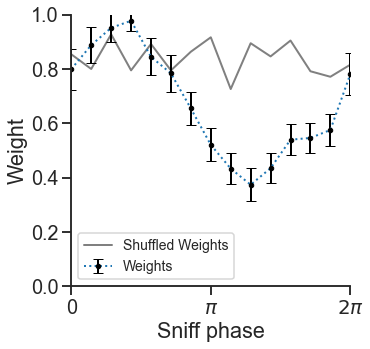

In [14]:
sns.set_style('ticks')
sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 2, "legend.fontsize":14})
sns.despine()

phase = np.linspace(0,2*np.pi,15)
plt.figure(figsize=(5,5))
#uplims = np.ones(15)
#plt.plot(phase,sniff_rolled,color='g')

plt.plot(phase,weights_shuffled_mean,'gray')
plt.errorbar(phase,weights_mean,yerr=weights_std,ecolor='k',capsize=5,marker='.',markerfacecolor='k',markeredgecolor='k', linestyle='dotted')
plt.legend(['Shuffled Weights','Weights'], loc='best')
plt.xlabel('Sniff phase')
plt.ylabel('Weight')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)
ax = plt.gca()
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_xticklabels(['0','$\pi$','$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig(savepath + 'sniff_kernel_match.png', format ='png', bbox_inches='tight', dpi=300)
plt.show()
plt.show()

In [15]:
sniff_kernel_std = kernels.std(axis=1).squeeze()


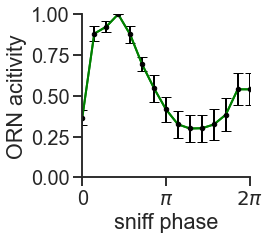

In [16]:
phase = np.linspace(0,2*np.pi,15)
plt.figure(figsize=(3,3))
plt.plot(phase,sniff_rolled,color='g')

#plt.plot(phase,weights_shuffled_mean,'gray')
plt.errorbar(phase,sniff_rolled,color='g',yerr=sniff_kernel_std,ecolor='k',capsize=5,marker='.',markerfacecolor='k',markeredgecolor='k')
plt.xlabel('sniff phase')
plt.ylabel('ORN acitivity')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)
ax = plt.gca()
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_xticklabels(['0','$\pi$','$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig('figures/sniff_kernel_ORN.svg')
plt.show()
plt.show()

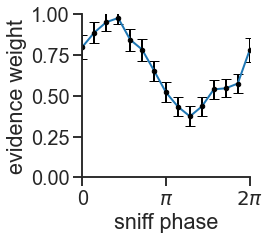

In [18]:
phase = np.linspace(0,2*np.pi,15)
plt.figure(figsize=(3,3))
plt.errorbar(phase,weights_mean,yerr=weights_std,ecolor='k',capsize=5,marker='.',markerfacecolor='k',markeredgecolor='k')
plt.xlabel('sniff phase')
plt.ylabel('evidence weight')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)
ax = plt.gca()
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_xticklabels(['0','$\pi$','$2\pi$'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig('figures/sniff_kernel_shuffled.svg')
plt.show()
plt.show()

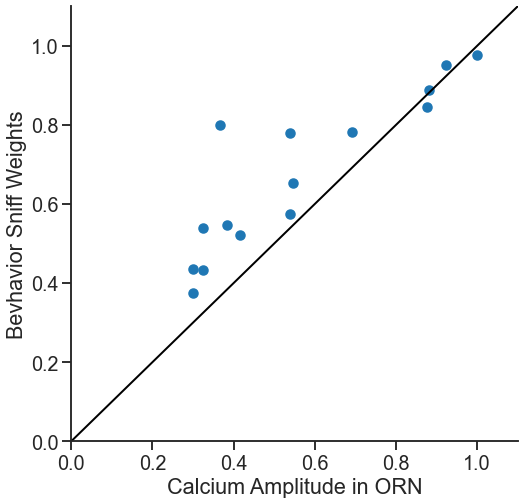

0.8854778013790251


In [20]:
xsk = sniff_rolled
ysk = weights_mean
slope, intercept, r_value, p_value, std_err = linregress(xsk,ysk)
xid = np.linspace(-1,2,20)
yid = np.linspace(-1,2,20)
plt.figure(figsize=(8,8))
plt.scatter(sniff_rolled,weights_mean)
plt.plot(xid,yid,'k')
plt.xlabel('Calcium Amplitude in ORN')
plt.ylabel('Bevhavior Sniff Weights')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig('figures/ca_vs_weights.svg')
plt.show()
print(r_value)

In [21]:
#Here is only analyzing the close to boundary trials (7-9 pulses) trials


num_processes = 16
N_bootstrap = 1200
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    print(animal_ind)
    norm_given_odor = all_cum_odor_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>6,norm_given_odor<10)
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
    print(all_sniff_hist_all.shape)
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
    weights = weights/weights.max()
    trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
    return accuracy,weights,trial_history

output_low = list()
    
for i in tnrange(num_iter):
    output_low.append(worker(0))

0
(284, 15)
1
(614, 15)
2
(893, 15)
3
(1105, 15)
4
(1199, 15)
5
(1332, 15)
6
(1455, 15)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [350]:
accuracy_list = list()
weights_list = list()
weights_shuffled_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output_low[i][0])
    weights_list.append(output_low[i][1])
    trial_history_list.append(output_low[i][2])
    
print(len(accuracy_list))#.shape)

accuracy_mat_low = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean_low = accuracy_mat_low.mean(axis=0)
print(accuracy_mean_low.shape)
accuracy_std_low = accuracy_mat_low.std(axis=0)
accuracy_error_low = 1.96*accuracy_std_low/np.sqrt(num_iter)

weights_mat_low = np.concatenate(weights_list).reshape(-1,15)
weights_mean_low = weights_mat_low.mean(axis=0)
weights_std_low = weights_mat_low.std(axis=0)
weights_error_low = 1.96*weights_std_low/np.sqrt(num_iter)

trial_history_mat_low = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean_low = trial_history_mat_low.mean(axis=0)
trial_history_std_low = trial_history_mat_low.std(axis=0)
trial_history_error_low = 1.96*trial_history_std_low/np.sqrt(num_iter)

1000
(4,)


In [254]:
#Here is only analyzing the correct trials

num_processes = 16
N_bootstrap = 10000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15))
all_sniff_hist_shuffled_all = np.zeros((0,15))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    all_correct_trials = all_correct_trials_list[animal_ind].astype(np.int).astype(np.bool)
    selected_trials = all_correct_trials
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
    
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
    weights = weights/weights.max()
    weights_shuffled = clf5.coef_[0][0:15]/clf5.coef_[0][0:15].max()
    weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
    return accuracy,weights,trial_history,weights_shuffled

output_correct = list()
    
for i in tnrange(num_iter):
    output_correct.append(worker(0))

    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [255]:
accuracy_list = list()
weights_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output_correct[i][0])
    weights_list.append(output_correct[i][1])
    trial_history_list.append(output_correct[i][2])

accuracy_mat_correct = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean_correct = accuracy_mat_correct.mean(axis=0)
accuracy_std_correct = accuracy_mat_correct.std(axis=0)
accuracy_error_correct = 1.96*accuracy_std_correct/np.sqrt(num_iter)    
    
weights_mat_correct = np.concatenate(weights_list).reshape(-1,15)
weights_mean_correct= weights_mat_correct.mean(axis=0)
weights_std_correct  = weights_mat_correct .std(axis=0)
weights_error_correct  = 1.96*weights_std_correct /np.sqrt(num_iter)

trial_history_mat_correct  = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean_correct = trial_history_mat_correct.mean(axis=0)
trial_history_std_correct = trial_history_mat_correct.std(axis=0)
trial_history_error_correct = 1.96*trial_history_std_correct/np.sqrt(num_iter)

In [256]:
#Here is only analyzing the wrong trials.

num_processes = 16
N_bootstrap = 2000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15))
all_sniff_hist_shuffled_all = np.zeros((0,15))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    all_correct_trials = all_correct_trials_list[animal_ind].astype(np.int).astype(np.bool)
    selected_trials = np.invert(all_correct_trials)
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
    
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
    weights = weights/weights.max()
    weights_shuffled = clf5.coef_[0][0:15]/clf5.coef_[0][0:15].max()
    weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
    return accuracy,weights,trial_history,weights_shuffled

output_wrong = list()
    
for i in tnrange(num_iter):
    output_wrong.append(worker(0))

    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [257]:
accuracy_list = list()
weights_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output_wrong[i][0])
    weights_list.append(output_wrong[i][1])
    trial_history_list.append(output_wrong[i][2])

accuracy_mat_wrong = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean_wrong = accuracy_mat_wrong.mean(axis=0)
accuracy_std_wrong = accuracy_mat_wrong.std(axis=0)
accuracy_error_wrong = 1.96*accuracy_std_wrong/np.sqrt(num_iter)
    
weights_mat_wrong = np.concatenate(weights_list).reshape(-1,15)
weights_mean_wrong = weights_mat_wrong.mean(axis=0)
weights_std_wrong = weights_mat_wrong.std(axis=0)
weights_error_wrong = 1.96*weights_std_wrong/np.sqrt(num_iter)

trial_history_mat_wrong = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean_wrong = trial_history_mat_wrong.mean(axis=0)
trial_history_std_wrong = trial_history_mat_wrong.std(axis=0)
trial_history_error_wrong = 1.96*trial_history_std_wrong/np.sqrt(num_iter)

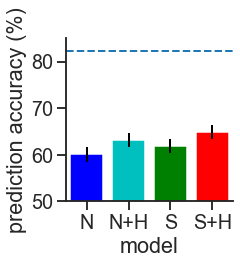

In [338]:
positions = [1,2,3,4]
plt.figure(figsize=(3,3))
plt.bar(positions[0],accuracy_mean_low[0],yerr=accuracy_std_low[0],color='b')
plt.bar(positions[1],accuracy_mean_low[1],yerr=accuracy_std_low[1],color='c')
plt.bar(positions[2],accuracy_mean_low[2],yerr=accuracy_std_low[2],color='g')
plt.bar(positions[3],accuracy_mean_low[3],yerr=accuracy_std_low[3],color='r')
plt.hlines(accuracy_mean.mean(),0,5,linestyle='--')
plt.xlim(0.5,4.5)
plt.ylim(50,85)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.xlabel('model')
plt.ylabel('prediction accuracy (%)')
#plt.legend(['all trials','boundary trials','correct_trial','wrong_trial'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 50})
#plt.savefig('figures/logistic_model_comparison.svg')
plt.show()

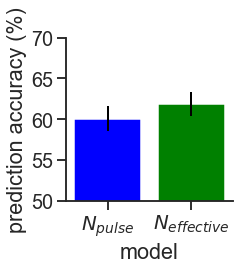

In [339]:
positions = [1,2]
plt.figure(figsize=(3,3))
plt.bar(positions[0],accuracy_mean_low[0],yerr=accuracy_std_low[0],color='b')
plt.bar(positions[1],accuracy_mean_low[2],yerr=accuracy_std_low[2],color='g')
plt.hlines(accuracy_mean.mean(),0,5,linestyle='--')
plt.xlim(0.5,2.5)
plt.ylim(50,70)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(['$N_{pulse}$','$N_{effective}$'])
plt.xlabel('model')
plt.ylabel('prediction accuracy (%)')
#plt.legend(['all trials','boundary trials','correct_trial','wrong_trial'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 50})
#plt.savefig('figures/logistic_model_comparison.svg')
plt.show()

In [340]:
accuracy_mean_low

array([60.06966667, 63.12325   , 61.89691667, 64.78008333])

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
num_processes = 16
N_bootstrap =12000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15))
all_sniff_hist_shuffled_all = np.zeros((0,15))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    norm_given_odor = all_cum_odor_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<20)
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
    
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
    weights = weights/weights.max()
    weights_shuffled = clf5.coef_[0][0:15]/clf5.coef_[0][0:15].max()
    weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
    return accuracy,weights,trial_history,weights_shuffled

output = list()
    
for i in tnrange(num_iter):
    output.append(worker(0))

    accuracy_list = list()
weights_list = list()
weights_shuffled_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output[i][0])
    weights_list.append(output[i][1])
    trial_history_list.append(output[i][2])
    weights_shuffled_list.append(output[i][3])

accuracy_mat = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean = accuracy_mat.mean(axis=0)
accuracy_std = accuracy_mat.std(axis=0)
accuracy_error = 1.96*accuracy_std/np.sqrt(num_iter)

weights_mat = np.concatenate(weights_list).reshape(-1,15)
weights_mean = weights_mat.mean(axis=0)
weights_std = weights_mat.std(axis=0)
weights_var = weights_mat.var(axis=0)
weights_error = 1.96*weights_std/np.sqrt(num_iter)

trial_history_mat = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean = trial_history_mat.mean(axis=0)
trial_history_std = trial_history_mat.std(axis=0)
trial_history_error = 1.96*trial_history_std/np.sqrt(num_iter)

weights_shuffled_mat = np.concatenate(weights_shuffled_list).reshape(-1,15)
weights_shuffled_mean = weights_shuffled_mat.mean(axis=0)
weights_shuffled_std = weights_shuffled_mat.std(axis=0)
weights_shuffled_error = 1.96*weights_shuffled_std/np.sqrt(num_iter)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [1]:
all_sniff_hist_all[0]

NameError: name 'all_sniff_hist_all' is not defined

In [8]:
import pandas as pd
N_bootstrap = 20000
ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))
X2 = all_sniff_hist_all[ind_bootstrap]
X = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
y = all_high_choices_all[ind_bootstrap]
lm = LogisticRegression().fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
weights = lm.coef_[0][0:15]
weights_norm = weights/weights.max()
predictions = lm.predict(X)

newX = np.append(np.ones((len(X),1)), X, axis=1)
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-scipy.stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

#sd_b = np.round(sd_b,3)
#ts_b = np.round(ts_b,3)
#p_values = np.round(p_values,3)
#params = np.round(params,4)
myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

    Coefficients  Standard Errors    t values  Probabilities
0      -4.397358         0.008590 -511.903036            0.0
1       0.487761         0.004459  109.386518            0.0
2       0.590718         0.004044  146.087882            0.0
3       0.580319         0.003798  152.806528            0.0
4       0.598572         0.003836  156.041269            0.0
5       0.510042         0.003859  132.167382            0.0
6       0.459750         0.003826  120.152765            0.0
7       0.405091         0.003813  106.242065            0.0
8       0.292741         0.003946   74.194985            0.0
9       0.250695         0.003925   63.867080            0.0
10      0.230007         0.003879   59.290358            0.0
11      0.291045         0.003808   76.432572            0.0
12      0.324349         0.003745   86.609270            0.0
13      0.364079         0.003619  100.596982            0.0
14      0.334372         0.003661   91.324176            0.0
15      0.496321        

In [10]:
weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)

#print(np.histogram((norm_given_odor_all), bins=np.arange(31)))[0]
#print(weights_norm)
#print(all_sniff_hist_all[0])
#print(weighted_odor[0:10])
#print(np.ceil(norm_given_odor_all[1660:1700]))

ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(10000,))
#print(ind_bootstrap)
new_high_choices =all_high_choices_all[ind_bootstrap]
#print(new_high_choices)

In [11]:
num_processes = 16
N_bootstrap = 10000
num_iter = 1000
batch_iter = 100
bound = (0.6,18)


bounds = list()
for i in range(22):
    bounds.append(bound)
bounds[1] = (-2,20)
num_batch = num_iter//batch_iter

weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)
#weighted_odor = np.ceil((all_sniff_hist_all*weights_norm).sum(axis=1)).astype(np.int)
res_array = np.zeros((22,num_iter))


    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    #new_cum_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20) #new_cum_odor

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        sig_Np = x[2:]
        return -compute_logp_correct_weighted(choices,new_weighted_odor,Nps,Nb,sig_dN,sig_Np) #Nps

    x0 = 6+np.random.rand(22)*5
    #x0[1] = 0
    res = minimize(loss,x0,bounds=bounds,method='BFGS',options={'norm':2})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,22).transpose()

resx_pool =np.zeros((22,2))
resx_pool[:,0] = res_array.mean(1)
resx_pool[:,1] = res_array.std(1)
#resx_pool[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)


  0%|          | 0/10 [00:00<?, ?it/s]

In [401]:
print(resx_pool)#[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)


[[5.48745746 0.08255628]
 [0.33996897 0.88252578]
 [2.28475697 0.33435753]
 [2.28088224 0.20983449]
 [2.26015646 0.24626155]
 [2.18896302 0.2212943 ]
 [2.29558521 0.29621954]
 [2.1799693  0.4102228 ]
 [1.7502507  0.55348158]
 [5.955833   4.64487889]
 [3.79874823 1.43969486]
 [3.49883285 0.62476955]
 [3.19765453 0.33685138]
 [3.43523549 0.31197878]
 [3.54426594 0.26767446]
 [3.76329903 0.28749628]
 [4.03007728 0.35138826]
 [4.17623481 0.35125225]
 [4.17792916 0.40431028]
 [5.05640124 0.59719085]
 [5.03763188 0.70790545]
 [3.57265656 3.55380938]]


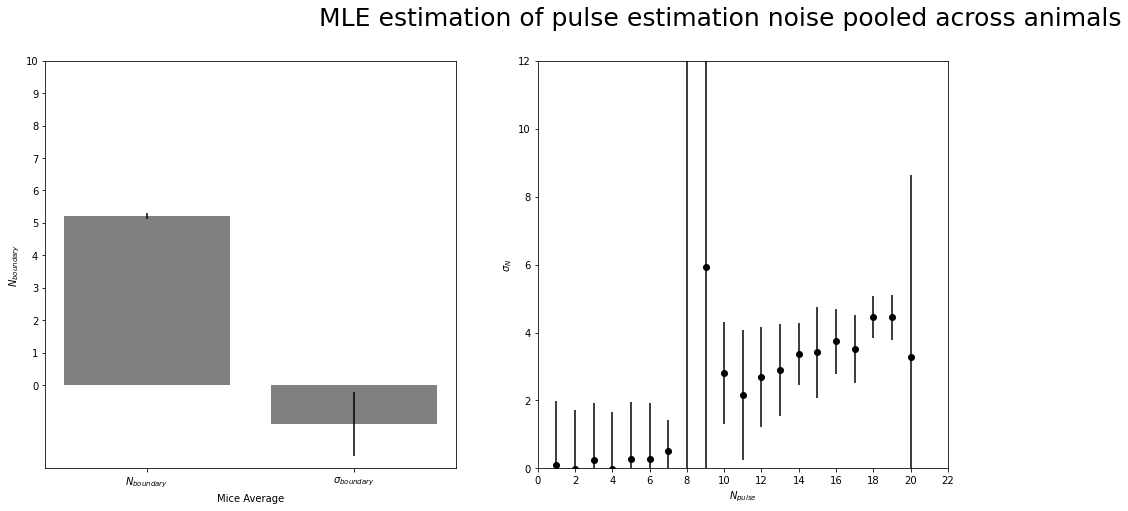

In [12]:
# plot noise estimation result
fig = plt.figure(figsize=(25,7.5))
fig.suptitle('MLE estimation of pulse estimation noise pooled across animals',size=25)
plt.subplot(1,3,2)
Nb_array = np.zeros((1,2))
sig_dN_array = np.zeros((1,2))
for i in range(1):
    plt.errorbar(x=np.arange(1,21),y=resx_pool[2:,0],yerr=resx_pool[2:,1],marker='o',color='black',linestyle = '')
    Nb_array[i,:] = resx_pool[0,:]
    sig_dN_array[i,:] = resx_pool[1,:]
plt.ylim(0,12)
plt.xticks(np.linspace(0,22,12))
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_{N}$')
plt.subplot(1,3,1)
for i in range(1):
    plt.bar(x=i+1,height=Nb_array[i,0],yerr=Nb_array[i,1],color='gray')
    plt.bar(x=i+2,height=sig_dN_array[i,0],yerr=sig_dN_array[i,1],color='gray')
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,3),('$N_{boundary}$','$\sigma_{boundary}$'))
plt.xlabel('Mice Average')
plt.ylabel('$N_{boundary}$')

#fig.savefig('../../figures/20190523/numeric_approximation_error_estimate_pooled.svg',format='svg')

plt.show()

In [405]:
num_processes = 16
N_bootstrap = 10000
num_iter = 1000
batch_iter = 100
bound = (0.000001,30)


bounds = list()
for i in range(3):
    bounds.append(bound)
num_batch = num_iter//batch_iter

weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)
#weighted_odor = np.ceil((all_sniff_hist_all*weights_norm).sum(axis=1)).astype(np.int)

res_array = np.zeros((3,num_iter))

    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    #new_cum_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        return -compute_logp_correct_sq_weighted(choices,new_weighted_odor,Nps,Nb,sig_dN,ksig,Nmax=20)

    x0 = 6+np.random.rand(3)*5
    
    res = minimize(loss,x0,bounds=bounds,method='BFGS',options={'norm':2})
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,3).transpose()

resx_pool_sq =np.zeros((3,2))
resx_pool_sq[:,0] = res_array.mean(1)
resx_pool_sq[:,1] = res_array.std(1)
phigh_est_sq = compute_phigh_sq(np.arange(1,21),resx_pool_sq[0,0],resx_pool_sq[1,0],resx_pool_sq[2,0],Nmax=20)


  0%|          | 0/10 [00:00<?, ?it/s]

In [406]:
print(resx_pool_sq)
resx_high = np.load('resx22.npy')
resx_sq_high = np.load('resx_pool_sq.npy')
print(resx_sq_high)
print(resx_pool_sq*(resx_sq_high[0,0]/resx_pool_sq[0,0]))

[[ -4755.19565878   3322.92094657]
 [ -6019.92497356   5013.24991174]
 [-13338.39001936   7462.48176002]]
[[8.24952342e+00 2.22044605e-13]
 [3.11714114e+00 5.06261699e-14]
 [1.21524329e+00 1.50990331e-14]]
[[  8.24952342  -5.76475   ]
 [ 10.44363168  -8.69720733]
 [ 23.14002802 -12.9462429 ]]


7.598402505745406
2.284756974376847


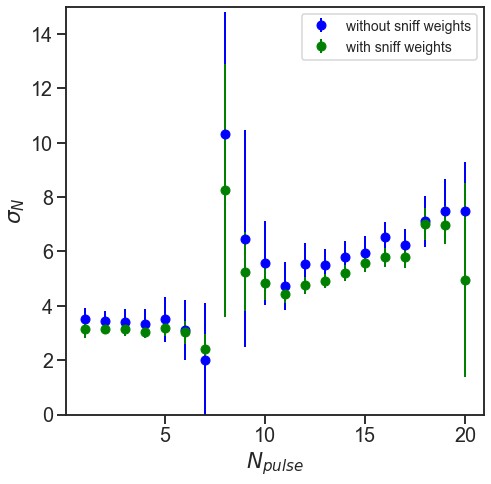

In [407]:
fig = plt.figure(figsize=(7.5,7.5))
x = np.arange(1,21)
y1 = resx_high[2:,0]
print(resx_high[0,0])
print(resx_pool[2,0])

y2 = resx_pool[2:,0]
y3 = resx_pool[2:,0]*resx_high[0,0]/resx_pool[0,0]
plt.errorbar(x=np.arange(1,21),y=y1,yerr=resx_high[2:,1],marker='o',color='blue',linestyle = '')
plt.errorbar(x=np.arange(1,21),y=y3,yerr=resx_pool[2:,1],marker='o',color='green',linestyle = '')
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_{N}$')
plt.ylim(0,15)
plt.legend(['without sniff weights','with sniff weights'])
#plt.savefig('figures/noise_scaling_with_sniff_weights.svg')
plt.show()


In [54]:
resx_high[10]

array([6.46071804, 3.98934248])

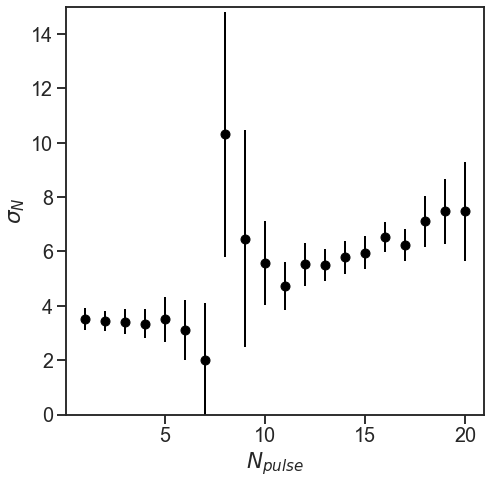

In [55]:
fig = plt.figure(figsize=(7.5,7.5))
x = np.arange(1,21)
y1 = resx_high[2:,0]
y2 = resx_pool[2:,0]*resx_high[0,0]/resx_pool[0,0]
plt.errorbar(x=np.arange(1,21),y=resx_high[2:,0],yerr=resx_high[2:,1],marker='o',color='black',linestyle = '')
#plt.errorbar(x=np.arange(1,21),y=resx_pool[2:,0],yerr=resx_pool[2:,1],marker='o',color='green',linestyle = '')
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_{N}$')
plt.ylim(0,15)
#plt.legend(['without sniff weights','with sniff weights'])
#plt.savefig('figures/noise_scaling_without_sniff_weights.svg')
plt.show()


<Figure size 432x288 with 0 Axes>

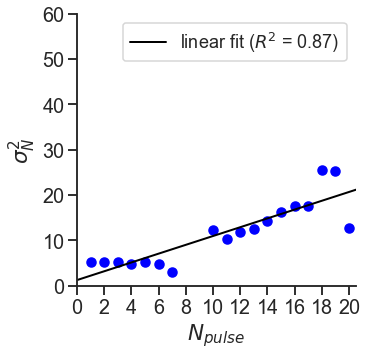

In [409]:
sns.set_style('ticks')
sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 2, "legend.fontsize":14})
sns.despine()


fig = plt.figure(figsize=(5,5))

x_selected = np.concatenate([np.arange(7),np.arange(9,20)])
x = x_selected + 1
y = y2[x_selected]**2
slope, intercept, r_value, p_value, std_err = linregress(x,y)
x_pred = np.arange(22)
y_pred = x_pred * slope + intercept
plt.plot(x_pred,y_pred,'k')

plt.scatter(x,y,color='b')
plt.xlim(0,20.5)
plt.ylim(0,60)
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N^2$')
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(np.linspace(0,20,11))
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value], fontsize = 18)
plt.show()
fig.savefig(savepath + 'linreg_noise_sniff.png',format='png', bbox_inches='tight', dpi=300)


In [57]:
r_value

0.9363758773978198

In [278]:
num_processes = 16
N_bootstrap = 1000
num_iter = 1000
batch_iter = 1
num_batch = num_iter//batch_iter

norm_given_odor_all = np.zeros((0,))
all_sniff_hist_all = np.zeros((0,15))
all_sniff_hist_shuffled_all = np.zeros((0,15))
all_previous_trial_all = np.zeros((0,num_hist))
all_correct_trials_all = np.zeros((0,))
all_high_choices_all = np.zeros((0,))


for animal_ind in range(len(all_correct_trials_list)):
    norm_given_odor = all_cum_odor_list[animal_ind]
    selected_trials = np.logical_and(norm_given_odor>0,norm_given_odor<20)
    norm_given_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_correct_trials = all_correct_trials_list[animal_ind][selected_trials].astype(bool)
    all_high_choices = all_high_choices_list[animal_ind][selected_trials]
    all_cum_odor = all_cum_odor_list[animal_ind][selected_trials]
    all_sniff_hist = all_sniff_hist_list[animal_ind][selected_trials]
    all_sniff_hist_shuffled = all_sniff_hist_shuffled_list[animal_ind][selected_trials]
    all_previous_trial = all_previous_trial_list[animal_ind][selected_trials]
    
    norm_given_odor_all = np.concatenate([norm_given_odor_all,norm_given_odor],axis=0)
    all_sniff_hist_all = np.concatenate([all_sniff_hist_all,all_sniff_hist],axis=0)
    all_sniff_hist_shuffled_all = np.concatenate([all_sniff_hist_shuffled_all,all_sniff_hist_shuffled],axis=0)
    all_high_choices_all = np.concatenate([all_high_choices_all,all_high_choices],axis=0)
    all_previous_trial_all = np.concatenate([all_previous_trial_all,all_previous_trial],axis=0)
    
    
    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(norm_given_odor_all),size=(N_bootstrap,))

    X1 = norm_given_odor_all[ind_bootstrap].reshape(-1,1)
    X2 = all_sniff_hist_all[ind_bootstrap]
    X3 = np.append(X2,all_previous_trial_all[ind_bootstrap],axis=1)
    X4 = np.append(X1,all_previous_trial_all[ind_bootstrap],axis=1)
    X5 = all_sniff_hist_shuffled_all[ind_bootstrap]
    y = all_high_choices_all[ind_bootstrap]

    clf1 = LogisticRegression().fit(X1, y)
    clf2 = LogisticRegression().fit(X2, y)
    clf3 = LogisticRegression().fit(X3, y)
    clf4 = LogisticRegression().fit(X4, y)
    clf5 = LogisticRegression().fit(X5, y)
    accuracy = [clf1.score(X1,y)*100,clf4.score(X4,y)*100,clf2.score(X2,y)*100,clf3.score(X3,y)*100]
    #weights = clf3.coef_[0][0:15]/clf3.coef_[0][0:15].max()
    weights = -clf3.coef_[0][0:15]/clf3.intercept_*8.26
    #weights = weights/weights.max()
    weights_shuffled = clf5.coef_[0][0:15]/clf5.coef_[0][0:15].max()
    weights_shuffled = weights_shuffled/weights_shuffled.max()
    trial_history = clf3.coef_[0][35:15:-1]/clf3.coef_[0][0:15].max()
    return accuracy,weights,trial_history,weights_shuffled

output = list()
    
for i in tnrange(num_iter):
    output.append(worker(0))


  0%|          | 0/1000 [00:00<?, ?it/s]

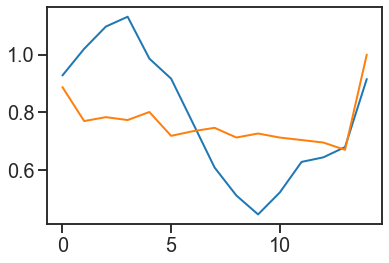

In [279]:

accuracy_list = list()
weights_list = list()
weights_shuffled_list = list()
trial_history_list = list()


for i in range(num_iter):
    accuracy_list.append(output[i][0])
    weights_list.append(output[i][1])
    trial_history_list.append(output[i][2])
    weights_shuffled_list.append(output[i][3])

accuracy_mat = np.concatenate(accuracy_list).reshape(-1,4)
accuracy_mean = accuracy_mat.mean(axis=0)
accuracy_std = accuracy_mat.std(axis=0)
accuracy_error = 1.96*accuracy_std/np.sqrt(num_iter)

weights_mat = np.concatenate(weights_list).reshape(-1,15)
weights_mean = weights_mat.mean(axis=0)
weights_std = weights_mat.std(axis=0)
weights_error = 1.96*weights_std/np.sqrt(num_iter)

trial_history_mat = np.concatenate(trial_history_list).reshape(-1,5)
trial_history_mean = trial_history_mat.mean(axis=0)
trial_history_std = trial_history_mat.std(axis=0)
trial_history_error = 1.96*trial_history_std/np.sqrt(num_iter)

weights_shuffled_mat = np.concatenate(weights_shuffled_list).reshape(-1,15)
weights_shuffled_mean = weights_shuffled_mat.mean(axis=0)
weights_shuffled_std = weights_shuffled_mat.std(axis=0)
weights_shuffled_error = 1.96*weights_shuffled_std/np.sqrt(num_iter)
#plt.plot(np.minimum(weights_mean,1-weights_mean)/np.minimum(weights_mean,1-weights_mean).max())
plt.plot(weights_mean)
plt.plot(weights_std/weights_std.max())
plt.show()

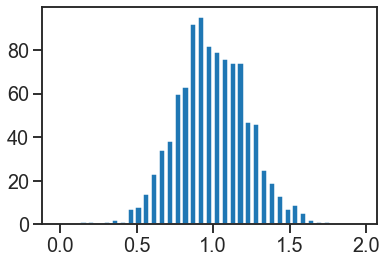

In [280]:
bins = np.linspace(0,2,40)
hist = np.histogram(weights_mat[:,1],bins=bins)
plt.bar(bins[:-1],hist[0],width=0.04)
plt.show()

In [281]:
ns = np.array([25,50,100,250,500,1000,2500,5000,10000])
weights_std_list = [weights_std25,weights_std50,weights_std100,weights_std250,weights_std500,weights_std1000,weights_std2500,weights_std5000,weights_std10000]
std_array = np.array(weights_std_list)
np.save('ns.npy',ns)
np.save('std_array.npy',std_array)

NameError: name 'weights_std25' is not defined

In [64]:
plt.plot(ns,std_array*np.sqrt(ns).reshape(9,1))
plt.show()

NameError: name 'std_array' is not defined

In [282]:
resx_high = np.load('resx22.npy')
resx_sq_high = np.load('resx_pool_sq.npy')
resx_pool_sq_norm = resx_pool_sq*(resx_sq_high[0,0]/resx_pool_sq[0,0])
print(resx_sq_high)
print(resx_pool_sq_norm)

[[8.24952342e+00 2.22044605e-13]
 [3.11714114e+00 5.06261699e-14]
 [1.21524329e+00 1.50990331e-14]]
[[8.24952342 0.08451662]
 [3.00708764 0.11468005]
 [0.99737302 0.02101917]]


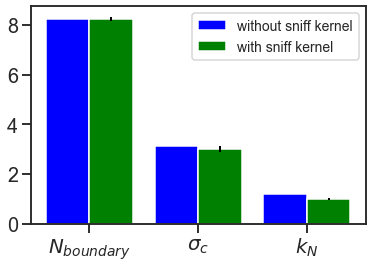

In [283]:
x = np.arange(3)
w = 0.4
fig, ax = plt.subplots()
ax.bar(x -w/2,resx_sq_high[:,0],yerr=resx_sq_high[:,1],width=w,color='blue')
ax.bar(x+w/2,resx_pool_sq_norm[:,0],yerr=resx_pool_sq_norm[:,1],width=w,color='green')
plt.xticks(np.arange(3),('$N_{boundary}$','$\sigma_{c}$','$k_{N}$'))
plt.legend(['without sniff kernel','with sniff kernel'])
fig.savefig(savepath + 'three_parameter_comparison.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

In [360]:
num_processes = 16
N_bootstrap = 10000
num_iter = 1000
batch_iter = 100
#bound = (0.01,50)

bounds = [(0.1,50), (-0.1, 50), (0.1, 50), (-10,50)]

# bounds = list()
# for i in range(3):
#     bounds.append(bound)
num_batch = num_iter//batch_iter

weighted_odor = (all_sniff_hist_all*weights_norm).sum(axis=1)
#weighted_odor = np.ceil((all_sniff_hist_all*weights_norm).sum(axis=1)).astype(np.int)

res_array = np.zeros((4,num_iter))

    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(all_high_choices_all),size=(N_bootstrap,))
    new_high_choices =all_high_choices_all[ind_bootstrap]
    new_cum_odor = norm_given_odor_all[ind_bootstrap]
    new_weighted_odor = weighted_odor[ind_bootstrap]
    #new_cum_odor = weighted_odor[ind_bootstrap]
    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,20)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        sig_0 = x[3]
        return -compute_logp_correct_lin_weighted(choices,new_weighted_odor,Nps,Nb,sig_0,sig_dN,ksig,Nmax=20)

    x0 = 6+np.random.rand(4)*5
    
    res = minimize(loss,x0,bounds=bounds,method='SLSQP',options={'maxiter':1000})
    return res.x

output = list()

with mp.Pool(processes=16) as pool:
        for i in tnrange(num_batch):
            batch_output = pool.map(worker,range(batch_iter))
            output.extend(batch_output)
        pool.close()

res_array = np.concatenate(output).reshape(-1,4).transpose()

resx_pool_lin =np.zeros((4,2))
resx_pool_lin[:,0] = res_array.mean(1)
resx_pool_lin[:,1] = res_array.std(1)
phigh_est_lin = compute_phigh_lin(np.arange(1,21),resx_pool_lin[0,0],resx_pool_lin[1,0],resx_pool_lin[2,0],0,Nmax=20)


  0%|          | 0/10 [00:00<?, ?it/s]

In [361]:
print(resx_pool_lin)
resx_lin_high = np.load('resx_pool_lin.npy')
resx_pool_lin_norm = resx_pool_lin*(resx_lin_high[0,0]/resx_pool_lin[0,0])

[[ 4.94580485  0.04889273]
 [ 0.02602795  0.21187616]
 [ 0.75199767  0.19291111]
 [-3.61252828  0.9508585 ]]


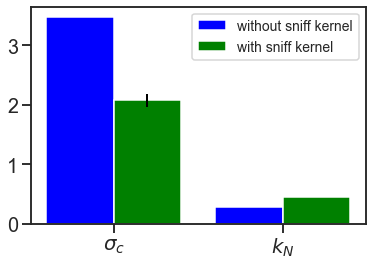

In [286]:
x = np.arange(2)
w = 0.4
fig, ax = plt.subplots()
ax.bar(x-w/2,resx_lin_high[1:3,0],yerr=resx_lin_high[1:3,1],width=w,color='blue')
ax.bar(x+w/2,resx_pool_lin_norm[1:4,0],yerr=resx_pool_lin_norm[1:4,1],width=w,color='green')
plt.xticks(np.arange(2),('$\sigma_{c}$','$k_{N}$'))
plt.legend(['without sniff kernel','with sniff kernel'])
#fig.savefig('figures/two_parameter_comparison.svg')
plt.show()

0.0478
20


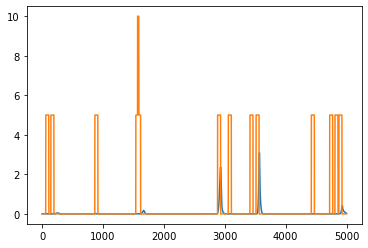

In [86]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

n = 36
a = all_conv_odor_list[0]

a_0 = all_trial_odor_list[0]
b = a[n]
i_prob = (b[:] > 0.1).mean()
print(i_prob)
b_0 = a_0[n]/20
c = ECDF(b)
d = gaussian_kde(b)
e = d.pdf(np.linspace(-2,2,5000))
plt.plot(b)
plt.plot(b_0)
#plt.plot(c.y)
#plt.plot(e)
print(num_bins)

In [87]:
num_bins=24
c_threshold = 0.1
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
perc_int_list = list()
for i in range(len(all_correct_trials_list)):
    conv_odor_animal = all_conv_odor_list[i]
    for j in range(len(conv_odor_animal)):
        conv_odor_trial = conv_odor_animal[j]
        perceived_intermittency = (conv_odor_trial[:] > c_threshold).mean()
        perc_int_list.append(perceived_intermittency)

    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list[i])
    
phigh = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
intermittency = np.zeros((num_bins,2))
bin_counts = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)
perc_int = np.asarray(perc_int_list)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    selected_int = perc_int[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts[i] = num_selected
    phigh[i,0] = selected.mean()
    phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    intermittency[i,0] = selected_int.mean()
    intermittency[i,1] = 1.69*selected_int.std()/np.sqrt(num_selected)


IndexError: index 20 is out of bounds for axis 0 with size 20

[0.03054662 0.04977376 0.0875721  0.14053487 0.22222222 0.29773756
 0.37735849 0.54929577 0.61016949 0.67176871 0.7579519  0.79218865
 0.84094368 0.86851521 0.8934338  0.90483163 0.93164557 0.92446043] [0.01166102 0.01009319 0.0109394  0.01344985 0.01726546 0.02324728
 0.03120852 0.04989723 0.04380748 0.02314104 0.02016192 0.01861426
 0.01705092 0.01708017 0.01710881 0.01897608 0.02145838 0.02678525]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

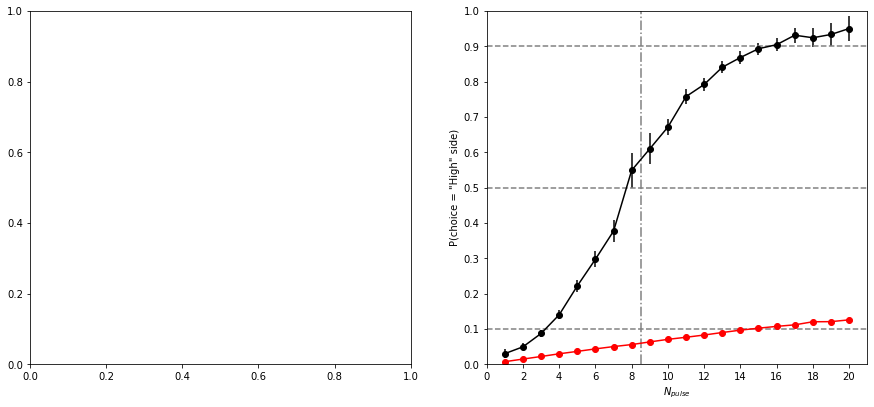

In [88]:
fig = plt.figure(figsize=(15,6.5))

c_2 = plt.cm.get_cmap('RdPu')


#fig.suptitle('Decision psychomatrics of pulse estimation pooled across animals',size=25)
plt.subplot(1,2,2)
plt.errorbar(x=pulse_bins[0:20],y=phigh[0:20,0],yerr=phigh[0:20,1],marker='o',color='black')
plt.errorbar(x=pulse_bins[0:20],y=intermittency[0:20,0],yerr=intermittency[0:20,1],marker='o',color='red')

plt.xlabel('$N_{pulse}$')
print(phigh[0:18,0], phigh[0:18,1])
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,21)

plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice = "High" side)')
plt.xticks(np.linspace(0,20,11))

plam_bins = calc_plam(pulse_bins,12.5,4.16667)
# plt.subplot(1,3,2)

# plt.errorbar(plam_bins[0:20],y=phigh[0:20,0],yerr=phigh[0:20,1],marker='o',color='black')
# plt.xlabel('$P(\lambda=\lambda_1|N_{pulse})$')
# plt.axhline(y=0.1,color='gray',linestyle='--')
# plt.axhline(y=0.5,color='gray',linestyle='--')
# plt.axhline(y=0.9,color='gray',linestyle='--')
# plt.ylim(0,1)
# plt.yticks(np.linspace(0,1,11))
# plt.ylabel('P(choice=high)')

plt.subplot(1,2,1)
bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[8:],bin_counts[8:]/1000,color=c_2(0.40), edgecolor = c_2(0.90), linewidth=0.8)
plt.bar(pulse_bins[:8],bin_counts[:8]/1000,color=c_2(0.15), edgecolor = c_2(0.90), linewidth=0.8)
plt.legend(['$\lambda1$ given','$\lambda2$ given'])
plt.xlim(0,21)
plt.xticks(np.linspace(0,20,11))#, fontsize = 14)#, rotation=70)
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('$N_{pulse}$')
plt.ylabel('Thousands of trials')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3)

#fig.savefig(savepath + 'behavior_psychometric_curve_pooled_20.svg',format='svg', bbox_inches='tight')
#fig.savefig(savepath + 'behavior_psychometric_curve_20.png',format='png', bbox_inches='tight')
plt.show()

<ErrorbarContainer object of 3 artists>

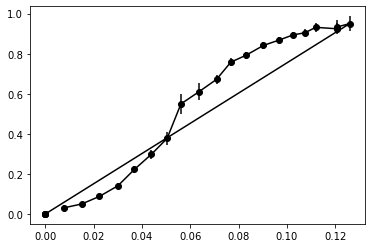

In [89]:
plt.errorbar(x=intermittency[0:24,0],y=phigh[0:24,0],yerr=phigh[0:24,1],marker='o',color='black')
#plt.errorbar(x=intermittency[0:20,0],y=intermittency[0:20,0],yerr=intermittency[0:20,1],marker='o',color='red')

In [295]:
num_bins_long = 20
half_num_bins_long = 8
min_pulse_long = 1
max_pulse_long = 20

pulse_bins_long = np.linspace(min_pulse_long,max_pulse_long,max_pulse_long-min_pulse_long+1)
phigh_long = np.zeros((num_bins_long,2))
performance_long = np.zeros((num_bins_long,2))
bin_counts_long = np.zeros((num_bins_long,))
pulse_bin_ind_long = np.ceil(pool_cum_odor).astype(np.int)

for i in range(num_bins_long):
    selected = pool_high_choices[pulse_bin_ind_long==pulse_bins_long[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind_long==pulse_bins_long[i]]
    num_selected = len(selected)
    bin_counts_long[i] = num_selected
    phigh_long[i,0] = selected.mean()
    phigh_long[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
    performance_long[i,0] = selected_correct.mean()
    performance_long[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    
print(bin_counts_long)

[ 622. 1326. 1907. 1907. 1656. 1105.  689.  284.  354. 1176. 1289. 1357.
 1314. 1118.  929.  683.  395.  278.  166.  101.]


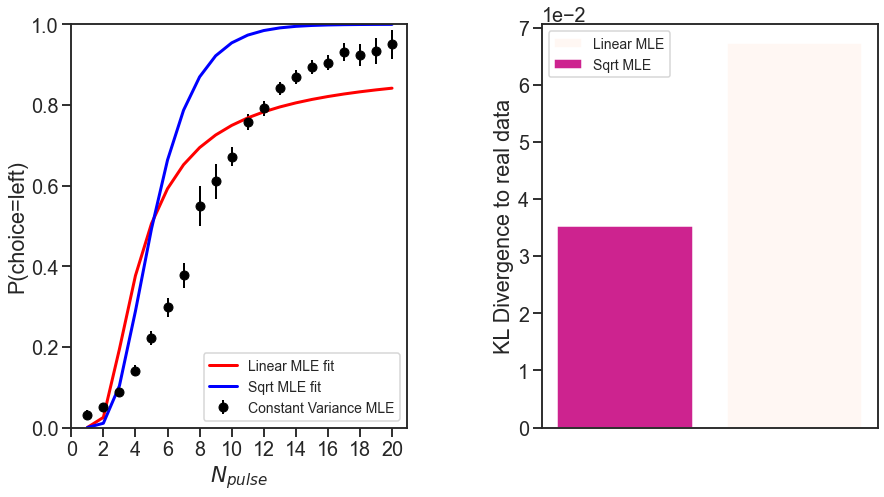

In [371]:
#print(bin_counts_long.shape)
colors = plt.cm.get_cmap('RdPu')
c_3 = colors(np.linspace(0,1,4))


fig = plt.figure(figsize=(14,7))
x_long = np.arange(min_pulse_long,max_pulse_long+1)
# slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x,y**2)
# y_fit_long1 = x_long*slope + intercept
# y_fit_long2 = np.sqrt(x_long*slope2)
# phigh_est_long1 = compute_phigh(x_long,resx_pool[0,0],resx_pool[1,0],y_fit_long1)
# phigh_est_long2 = compute_phigh(x_long,resx_pool[0,0],resx_pool[1,0],y_fit_long2)

# kl1 = entropy(phigh_est_long1*bin_counts_long,phigh_long[:,0]*bin_counts_long)
# kl2 = entropy(phigh_est_long2*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_sq = entropy(phigh_est_sq*bin_counts_long,phigh_long[:,0]*bin_counts_long)
kl_lin = entropy(phigh_est_lin*bin_counts_long,phigh_long[:,0]*bin_counts_long)
# kl_pow = entropy(phigh_est_pow*bin_counts_long,phigh_long[:,0]*bin_counts_long)
# kl_const = entropy(phigh_est_const*bin_counts_long,phigh_long[:,0]*bin_counts_long)


plt.subplot(1,2,1)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
#plt.plot(x_long,phigh_est_long1,color=c_3[0], linewidth=3)
#plt.plot(x_long,phigh_est_long2,color=c_3[1], linewidth=3)
plt.plot(x_long,phigh_est_lin,color='red', linewidth=3)
#plt.plot(x_long,phigh_est_pow,color=c_3[1], linewidth=3)
plt.plot(x_long,phigh_est_sq,color='blue', linewidth=3)
#plt.plot(x_long,phigh_est_const,color=c_3[3], linewidth=3)

plt.xticks(np.linspace(0,20,11))
plt.ylabel('P(choice=left)')
plt.xlabel('$N_{pulse}$')
plt.legend(['Linear MLE fit', 'Sqrt MLE fit', 'Constant Variance MLE', 'Behavioral Data'], loc='lower right')
plt.ylim(0,1)


plt.subplot(1,2,2)
#plt.bar(1,kl1)
plt.bar(3,kl_lin, color=c_3[0])
plt.bar(2,kl_sq, color=c_3[2])
#plt.bar(4,kl_pow,color=c_3[1])
#plt.bar(1,kl_const,color=c_3[3])

plt.ylabel('KL Divergence to real data')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
plt.xticks([])
plt.legend(['Linear MLE','Sqrt MLE','Pow MLE','Constant Variance MLE'])
#plt.xticks(np.arange(1,5),['Constant Variance MLE','Sqrt MLE','Linear MLE', 'Power MLE'])

''''
plt.subplot(2,2,1)

plt.plot(x_long,phigh_est_long1)
plt.plot(x_long,phigh_est_long2)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',linestyle='',color='black')
plt.legend(['phigh_est_long1','phigh_est_long2','real data'])
plt.ylim(0,1)
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')

plt.subplot(2,2,4)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
plt.plot(x_long,phigh_est_pow,color='black')
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')
plt.legend(['sqrt MLE fit','real data'])
plt.ylim(0,1)


'''
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)



#fig.savefig(savepath +'fit_comparison.svg',format='svg', bbox_inches='tight')
#fig.savefig(savepath +'fit_comparison.png',format='png', bbox_inches='tight')

plt.show()
#print(bin_counts_long)
#print(kl_sq)